# Acquisition functions

An acquisition function dictates the exploration policy of the optimizer. In practice, there are many different acquisition policies and which one is the best might depend on your situation. This package comes with several acquisition functions out-of-the-box, but it is also very easy to write your acquisition function. This notebook showcases how to do that using various examples.

Let's begin with a few import statements and some function definitions we will use later.

In [1]:
from bayes_opt import BayesianOptimization
from bayes_opt import acquisition
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
def target(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

x = np.linspace(-2, 10, 1000).reshape(-1, 1)
y = target(x)

def posterior(optimizer, grid):
    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y):
    acquisition_function_ = optimizer.acquisition_function
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontsize=30
    )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    acquisition_function_._fit_gp(optimizer._gp, optimizer._space)
    mu, sigma = posterior(optimizer, x)

    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})

    utility = -1 * acquisition_function_._get_acq(gp=optimizer._gp)(x)
    x = x.flatten()

    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((-2, 10))
    #acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    return fig, fig.axes

Most (simple) acquisition operate directly on the estimates of mean and standard deviation of the GP. For this, all it takes is to implement a `.base_acq` function, which combines the `mean`/`std` values into an acquisition policy. One very simple such function could simple disregard the `std` and always opt to investigate the maximum of the GP `mean`.

In [3]:
class GreedyAcquisition(acquisition.AcquisitionFunction):
    def __init__(self, random_state=None):
        super().__init__(random_state)
    
    def base_acq(self, mean, std):
        return mean # disregard std

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.5721    | -0.8809   |
| 2         | 0.9973    | 6.511     |
| 3         | 0.7985    | 4.267     |
| 4         | 0.9958    | 6.525     |
| 5         | 1.024     | 6.132     |
| 6         | 1.027     | 6.024     |
| 7         | 1.027     | 5.975     |
| 8         | 1.027     | 5.964     |
| 9         | 1.027     | 5.962     |
| 10        | 1.027     | 5.961     |


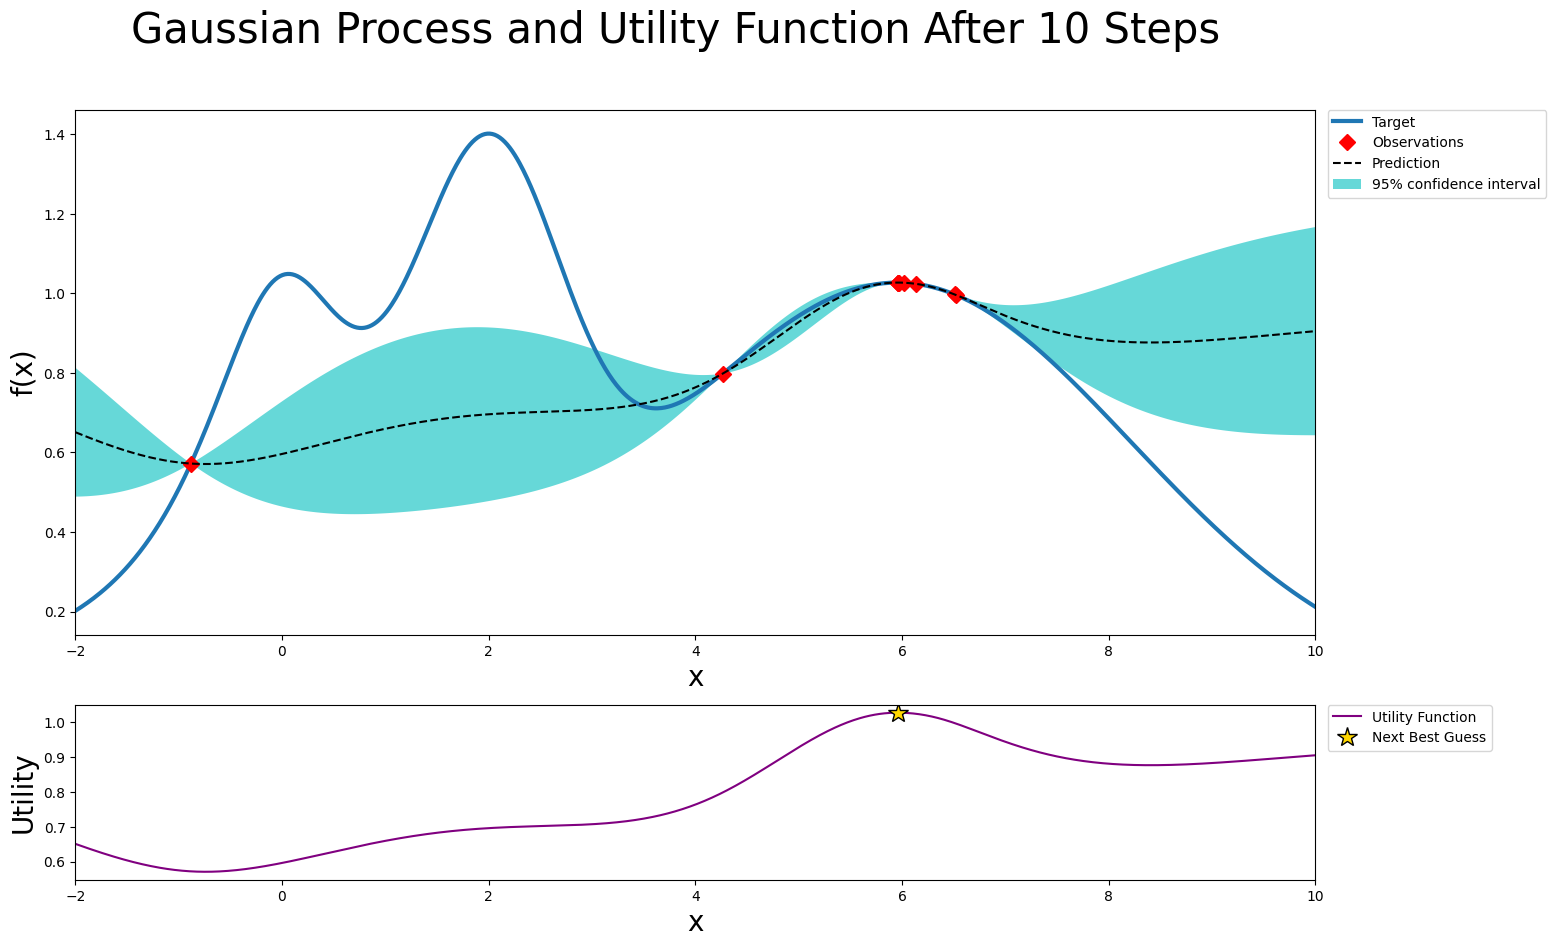

In [4]:
acquisition_function = GreedyAcquisition(random_state=42)
optimizer = BayesianOptimization(target, {'x': (-2, 10)}, acquisition_function=acquisition_function, random_state=173)
optimizer.maximize(init_points=3, n_iter=7)

plot_gp(optimizer, x, y);

As we can see, the greedy policy is _too_ greedy and does not explore enough to find the maximum.

What if our acquisition function does not depend solely on `mean` and `std`? In that case, we can intervene at a deeper level, and overwrite the `._get_acq` function. The built-in version of `._get_acq` is a higher-order function which returns a function accepting an array-like `x` and performing the following:
1. Evaluate the GP mean $\mu$ and std $\sigma$ at points `x`.
2. If applicapable, evaluate the constraint fulfilment probability $p_c$ at x.
3. Return `-1 * base_acq(mean, std)` or `-1 * base_acq(mean, std) * p_c`

An example of such an acquisition function is Thompson Sampling. If you consider a Gaussian Process as a prior over functions, Thompson Sampling works by sampling a function from this prior and then selecting the argmax as next point of interest. This is a somewhat noisy version of the greedy acquisition, which will encourage some exploration.

While we usually find the argmax of the acquisition function through a combination of random sampling and gradient-based optimization, we will skip the gradient-based optimization here, as it is quite expensive and would require us to fix the multivariate normal. We can do this by additionally overwriting `.suggest`, specifically by changing the default argument of `n_l_bfgs_b` to `0`.

In [5]:
import warnings

class ThompsonSampling(acquisition.AcquisitionFunction):
    def __init__(self, random_state=None):
        super().__init__(random_state)

    def base_acq(self, y_mean, y_cov):
        assert y_cov.shape[0] == y_cov.shape[1], "y_cov must be a square matrix."
        return self.random_state.multivariate_normal(y_mean, y_cov)

    def _get_acq(self, gp, constraint=None):
        if constraint is not None:
            msg = (
                f"Received constraints, but acquisition function {type(self)} "
                + "does not support constrained optimization."
            )
            raise acquisition.ConstraintNotSupportedError(msg)

        # overwrite the base method since we require cov not std
        dim = gp.X_train_.shape[1]
        def acq(x):
            x = x.reshape(-1, dim)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                mean, cov = gp.predict(x, return_cov=True)
            return -1 * self.base_acq(mean, cov)
        return acq

    def suggest(self, gp, target_space, n_random=1_000, n_l_bfgs_b=0, fit_gp: bool = True):
        # reduce n_random and n_l_bfgs_b to reduce the computational load
        return super().suggest(gp, target_space, n_random, n_l_bfgs_b, fit_gp)


|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.5721    | -0.8809   |
| 2         | 0.9973    | 6.511     |
| 3         | 0.7985    | 4.267     |
| 4         | 0.7342    | 7.82      |
| 5         | 0.9227    | 0.8877    |
| 6         | 0.5426    | 8.523     |
| 7         | 0.2361    | 9.857     |
| 8         | 1.027     | 6.039     |
| 9         | 1.025     | 5.801     |
| 10        | 1.027     | 5.934     |
Adding GP samples to the plot... this can take up to several minutes.


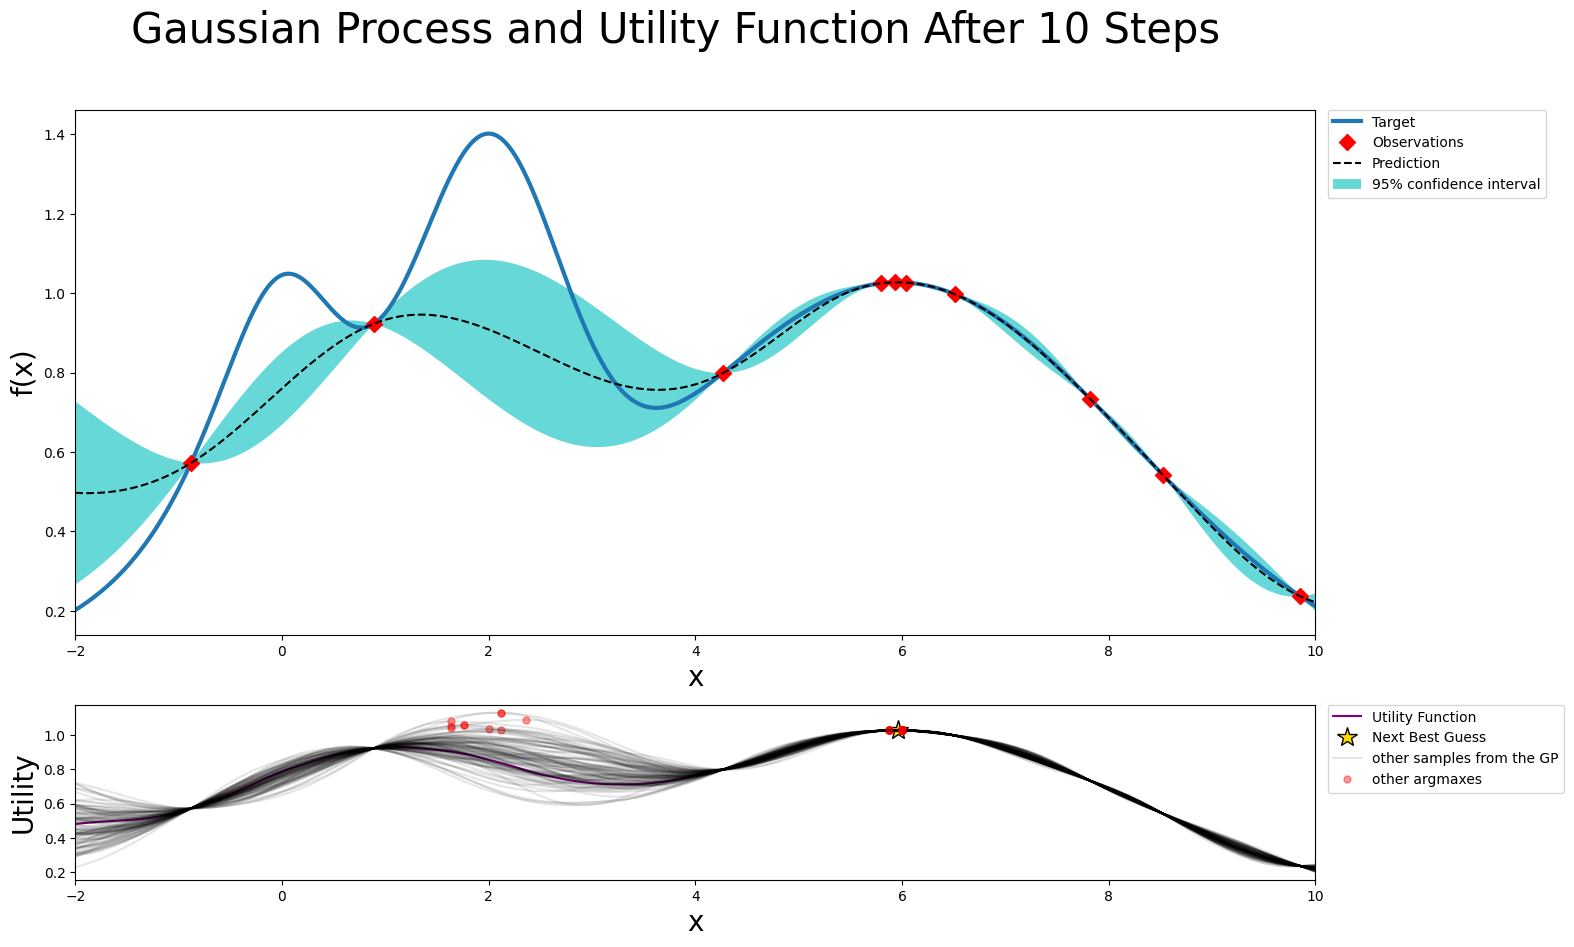

In [6]:
acquisition_function = ThompsonSampling(random_state=13)
optimizer = BayesianOptimization(target, {'x': (-2, 10)}, acquisition_function=acquisition_function, random_state=173)
optimizer.maximize(init_points=3, n_iter=7)

fig, axs = plot_gp(optimizer, x, y);

print("Adding GP samples to the plot... this can take up to several minutes.")

x_reduced = np.linspace(-2, 10, 100).reshape(-1, 1)
for i in range(99):
    y_sample = -1 * acquisition_function._get_acq(gp=optimizer._gp)(x_reduced)
    y_sample_argmax = (x_reduced[np.argmax(y_sample)], np.max(y_sample))
    axs[1].plot(x_reduced, y_sample, 'k', alpha=0.1, label='other samples from the GP' if i == 0 else None)
    axs[1].plot(*y_sample_argmax, 'r.', alpha=0.4, markersize=10, label='other argmaxes' if i == 0 else None)

axs[1].legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.);

Let's push things even further!

In some situations, you might be working in a setting where evaluations are not equally expensive. For example, let's say that you're running an expensive mechanical experiment, and performing the experiment is cheap, but adjusting its parameters is an expensive process. In particular, the further away it is from the current set-up, the more expensive it becomes. In such a situation, you could factor in the expense by running a specialized version of Expected Improvement (EI) called EIpu (EI per unit cost). Here we divide the EI by a specific cost function.

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.5721    | -0.8809   |
| 2         | 0.9973    | 6.511     |
| 3         | 0.7985    | 4.267     |
| 4         | 1.016     | 5.617     |
| 5         | 1.027     | 5.932     |
| 6         | 0.45      | 8.875     |
| 7         | 1.026     | 6.076     |
| 8         | 1.027     | 5.954     |
| 9         | 1.027     | 5.955     |
| 10        | 1.027     | 5.953     |


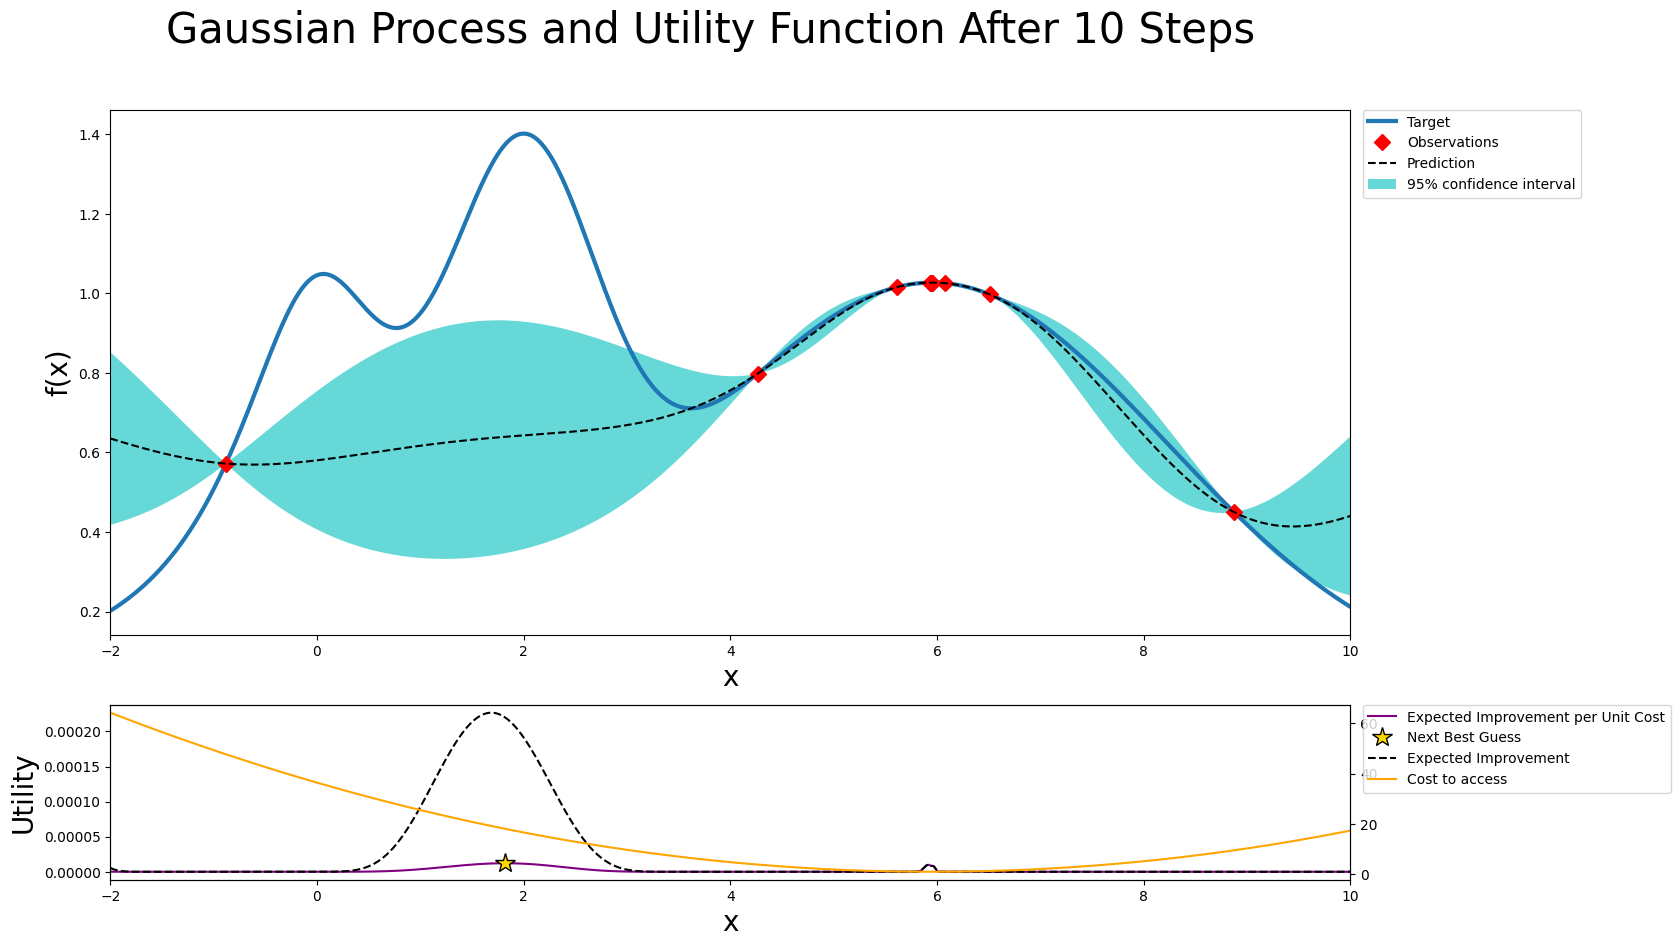

In [7]:
class ExpectedImprovementPerUnitCost(acquisition.ExpectedImprovement):
    def __init__(self, xi, exploration_decay=None, exploration_decay_delay=None, random_state=None) -> None:
        super().__init__(xi, exploration_decay, exploration_decay_delay, random_state)
        self.last_x = None

    def cost(self, x):
        if self.last_x is None:
            return 1
        return np.mean((self.last_x - np.atleast_2d(x))**2, axis=1) + 1.

    def _get_acq(self, gp, constraint=None):
        super_acq = super()._get_acq(gp, constraint)
        acq = lambda x: super_acq(x) / self.cost(x)
        return acq

    def suggest(self, gp, target_space, n_random=10000, n_l_bfgs_b=10, fit_gp: bool = True):
        # let's get the most recently evaluated point from the target_space
        self.last_x = target_space.params[-1]
        return super().suggest(gp, target_space, n_random, n_l_bfgs_b, fit_gp)

acquisition_function = ExpectedImprovementPerUnitCost(1e-4, random_state=42)
optimizer = BayesianOptimization(target, {'x': (-2, 10)}, acquisition_function=acquisition_function, random_state=173)
optimizer.maximize(init_points=3, n_iter=7)

fig, axs = plot_gp(optimizer, x, y)

ax2 = axs[1].twinx()
ax2.plot(x, acquisition_function.cost(x), label='Cost to access', color='orange')

axs[1].plot(x, -1 * super(acquisition.ExpectedImprovement, acquisition_function)._get_acq(gp=optimizer._gp)(x), 'k--', label='Expected Improvement')

lines, labels = axs[1].get_legend_handles_labels()
labels[0] = 'Expected Improvement per Unit Cost'
lines2, labels2 = ax2.get_legend_handles_labels()
axs[1].legend().remove()
ax2.legend(lines + lines2, labels + labels2, loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.);